<a href="https://colab.research.google.com/github/Pepcoders/Data-Science-March/blob/main/GAN/AnimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download splcher/animefacedataset

 98% 385M/395M [00:03<00:00, 130MB/s]
100% 395M/395M [00:03<00:00, 119MB/s]


In [6]:
!mkdir animefacedataset

In [7]:
cd /content/animefacedataset

/content/animefacedataset


In [8]:
!unzip /content/animefacedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [9]:
import os
DATA_DIR = '/content/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [10]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [11]:
image_size = 64 
batch_size = 128 
# means of 0.5 and standard deviation 0.5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    # converting image 
    T.CenterCrop(image_size),
    # CentreCrop image 
    T.ToTensor(),
    # coverting image into tensor 
    T.Normalize(*stats)]))
    # Normalizing dataset (mean substract then diveide standard deviation )

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

In [13]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# for denormalizing image -> original value 
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [16]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

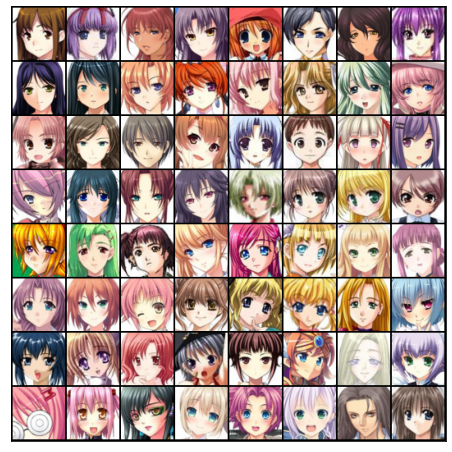

In [17]:
show_batch(train_dl)

In [21]:
# function for checking gpu device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    #it will a tensor or model and move to a specific device  
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



In [22]:
# it will load data to device 
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
# to check we have gpu or cpu
device = get_default_device()
device

device(type='cuda')

In [24]:
# loading data to device 
train_dl = DeviceDataLoader(train_dl, device)

In [26]:
import torch.nn as nn


In [27]:
# sequence of layer 
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # activation function
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
# it will convert output in 0 or 1

In [28]:
discriminator = to_device(discriminator, device)

In [29]:
latent_size = 128

In [30]:
# generator network -> it will take a vector of random number - tensor  and 
# generator will use this tensor as a seeds to generate image
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


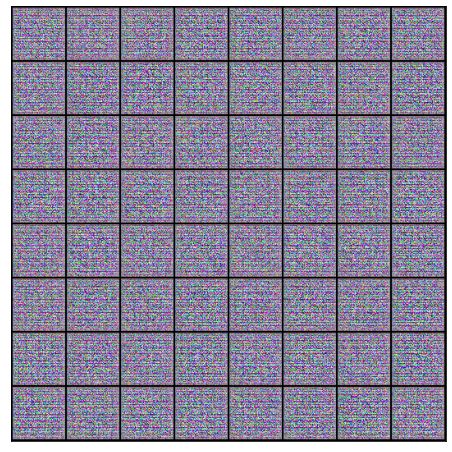

In [31]:
xb=torch.randn(batch_size,latent_size,1,1)

fake_images=generator(xb)
print(fake_images.shape)

show_images(fake_images)

In [32]:
generator = to_device(generator, device)

In [33]:
# probability training our descrminator 
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    # after backword descriminator will able to predict more accurate images
    opt_d.step() #it will update weights 
    return loss.item(), real_score, fake_score

In [35]:
# training our generator 
# -> genrator ko es tarah hume train krna hai ki vo descriminator ko fool ban ske 
# in this we will not update our discreminator , instead we will use loss of descriminator to train our generator 
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [36]:
from torchvision.utils import save_image

In [37]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [38]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [39]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


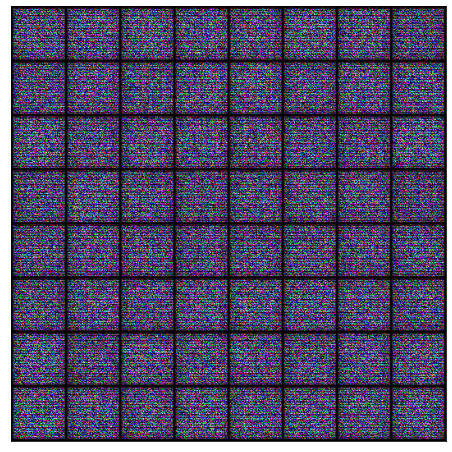

In [40]:
save_samples(0, fixed_latent)

In [41]:
# progress bar 
from tqdm.notebook import tqdm 
import torch.nn.functional as F

In [42]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [43]:
lr = 0.0002
epochs = 10

In [44]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 4.4150, loss_d: 1.4411, real_score: 0.3451, fake_score: 0.0050
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 3.3920, loss_d: 0.5724, real_score: 0.6959, fake_score: 0.1068
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 2.9473, loss_d: 0.2072, real_score: 0.8784, fake_score: 0.0412
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.4197, loss_d: 0.1745, real_score: 0.9079, fake_score: 0.0579
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.1914, loss_d: 0.1775, real_score: 0.9469, fake_score: 0.1016
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 5.9271, loss_d: 0.1231, real_score: 0.9500, fake_score: 0.0611
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.5565, loss_d: 0.1718, real_score: 0.9481, fake_score: 0.1002
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.9882, loss_d: 0.2413, real_score: 0.8504, fake_score: 0.0175
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.6052, loss_d: 0.0923, real_score: 0.9646, fake_score: 0.0512
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 15.2144, loss_d: 0.4880, real_score: 0.9452, fake_score: 0.2900
Saving generated-images-0010.png


In [45]:
import cv2
import os

vid_fname = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()